In [67]:
!python3 -m pip install docplex

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 633.5/633.5 kB 27.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docplex: filename=docplex-2.25.236-py3-none-any.whl size=671365 sha256=ccc75388d7e64cf71154f1486f5605e4872b6a4af3a9e70c906dc93f41a7e0f7
  Stored in directory: /root/.cache/pip/wheels/3b/e5/00/0bf0173d67188fe73a13e3a61412b3f975f60205e3fab93a69
Successfully built docplex


In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [1]:
!python3 -m pip install networkx


Python 3.11.2


# Traffic matrices and server popularity distributions

In [3]:
def generate_traffic_matrix(sending, receiving):
    # normalize vectors
    sending = sending / np.linalg.norm(sending)
    receiving = receiving / np.linalg.norm(receiving)

    # sending and receiving are vectors of length n, reshape them to be nx1 and 1xn
    sending = np.reshape(sending, (len(sending), 1))
    receiving = np.reshape(receiving, (1, len(receiving)))
    
    # multiply the two vectors to get an nxn matrix 
    matrix = sending @ receiving
    np.fill_diagonal(matrix, 0)
    
    return matrix / np.sum(matrix)

In [4]:
def generate_unif(n):
    # generate a uniform vector of length n
    return np.ones(n) / n

In [5]:
def generate_random(n):
    # generate a random vector of length n
    popularities = np.random.rand(n)
    return popularities / np.linalg.norm(popularities)

In [6]:
def generate_gaussian(n, std=0.1):
    # generate a uniform vector of length n, with some Gaussian noise added. default std is 0.1
    popularities = np.random.rand(n) + np.random.normal(0, std, n)
    return popularities / np.linalg.norm(popularities)

In [7]:
# Generate popularities according to Pareto dist

def generate_zipf(n, repeat=1):
    """Returns nodes' popularities according to Zipf dist
    ARGS:
        n: number of nodes
        repeat: number of nodes with 1/i popularity
        
    OUTPUTS:
        popularities: list of popularity for each node, following an approximate Zipf distribution
    """
    
    popularities = np.array([1/np.ceil(i/repeat) for i in range(1,n+1)]) # repeated Zipf function
    return popularities / np.linalg.norm(popularities) # normalize


# Jellyfish

In [8]:
def create_jellyfish(num_switches, other_switches_per_switch, servers_per_switch):
    """
    Args: (num_switches=N, other_switches_per_switch=r, servers_per_switch=k-r), supports N*(k-r) servers
    Returns: graph with all vertices + list of servers
    """
    # indices 0 to num_switches - 1 are switches
    G = nx.random_regular_graph(d=other_switches_per_switch, n=num_switches)
    
    # indices num_switches to num_switches + num_switches * servers_per_switch - 1 are servers
    for i in range(num_switches):
        for j in range(servers_per_switch):
            server_index = num_switches + i * servers_per_switch + j 
            G.add_node(server_index)
            G.add_edge(i, server_index)
            # servers.append(server_index)
    
    # list of all servers
    servers = range(num_switches, num_switches + num_switches * servers_per_switch)
    
    return G, servers


range(50, 250)
3


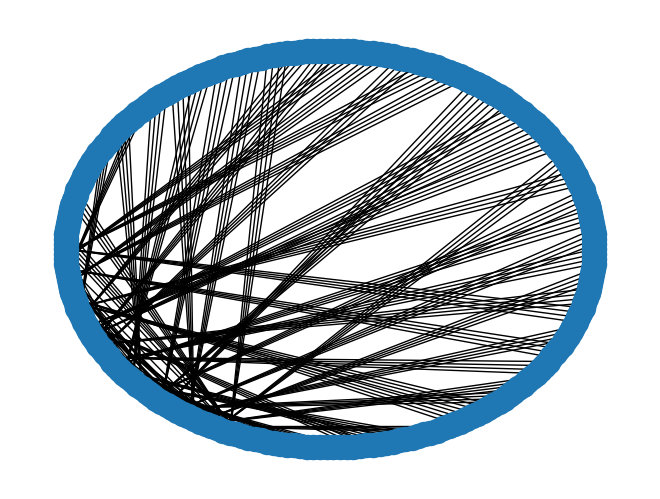

In [12]:
G, servers = create_jellyfish(num_switches=50, other_switches_per_switch=4, servers_per_switch=4)
# G, servers = create_jellyfish(num_switches=10, other_switches_per_switch=3, servers_per_switch=2)
print(servers)
print(nx.shortest_path_length(G, source=30, target=55))
pos = nx.shell_layout(G)
nx.draw(G, pos)
plt.show()

In [13]:
def switch_weight(source, target, edge_attr):
    if source in servers or target in servers:
        return 1
    else:
        return 0.144101239*len(servers) # https://ibmathsresources.com/2022/06/04/finding-the-average-distance-in-a-polygon/
    

def distance_weight(source, target, edge_attr):
    if source in servers or target in servers:
        return 1
    else:
        return np.abs(target-source)
    
nx.shortest_path_length(G, source=130, target=155, weight=distance_weight)


40

In [14]:
def calculate_weighted_path_length(G, servers, edge_weight=None):
    num_servers = len(servers)
    servers = np.random.permutation(servers) # randomly permute servers

    shortest_path_lengths = np.zeros((num_servers, num_servers))
    for i in range(num_servers):
        for j in range(num_servers):
            shortest_path_lengths[i, j] = nx.shortest_path_length(G, source=servers[i], target=servers[j], weight=edge_weight)

    # unif_traffic_matrix = generate_traffic_matrix(generate_unif(num_servers), generate_unif(num_servers)) 
    unif_server = generate_unif(num_servers)
    unif_traffic_matrix = generate_traffic_matrix(unif_server, unif_server)
    print("Uniform traffic", np.sum(np.multiply(shortest_path_lengths, unif_traffic_matrix)))

    # random_traffic_matrix = generate_traffic_matrix(generate_random(num_servers), generate_random(num_servers))
    random_server = generate_random(num_servers)
    random_traffic_matrix = generate_traffic_matrix(random_server, random_server)
    print("Random traffic", np.sum(np.multiply(shortest_path_lengths, random_traffic_matrix)))

    # gaussian_traffic_matrix = generate_traffic_matrix(generate_gaussian(num_servers, std=0.25), generate_gaussian(num_servers, std=0.25))
    gaussian_server = generate_gaussian(num_servers, std=0.25)
    gaussian_traffic_matrix = generate_traffic_matrix(gaussian_server, gaussian_server)
    print("Gaussian traffic", np.sum(np.multiply(shortest_path_lengths, gaussian_traffic_matrix)))

    # zipf_traffic_matrix = generate_traffic_matrix(generate_zipf(num_servers, repeat=5), generate_zipf(num_servers, repeat=5))
    zipf_server = generate_zipf(num_servers, repeat=5)
    zipf_traffic_matrix = generate_traffic_matrix(zipf_server, zipf_server)
    print("Zipf traffic", np.sum(np.multiply(shortest_path_lengths, zipf_traffic_matrix)))

    

In [ ]:
calculate_weighted_path_length(G, servers, edge_weight=switch_weight)

Uniform traffic 85.62795924438191
Random traffic 85.83220374624601
Gaussian traffic 85.79727242818316
Zipf traffic 87.24820920750189


In [ ]:
calculate_weighted_path_length(G, servers, edge_weight=distance_weight)

Uniform traffic 33.581105527638194
Random traffic 34.25484543112136
Gaussian traffic 33.343953700683656
Zipf traffic 32.46739516561077


# Fat-Tree

In [15]:
def create_fattree(ports_per_switch):
    core_switches = ports_per_switch ** 2 // 2
    agg_switches = ports_per_switch ** 2 // 2
    edge_switches = ports_per_switch ** 2 // 2
    servers = ports_per_switch ** 3 // 4
    print("switches", core_switches + agg_switches + edge_switches, "servers", servers)

    G = nx.Graph()
    G.add_nodes_from(range(core_switches + agg_switches + edge_switches + servers))

    # connect core switches to agg switches
    for i in range(core_switches): # i is core switch index
        for j in range(agg_switches): # j is agg switch index
            if j%2 == 0 and i < ports_per_switch//2:
                G.add_edge(i, core_switches + j)
            elif j%2 == 1 and i >= ports_per_switch//2:
                G.add_edge(i, core_switches + j)
    
    # connect agg switches to edge switches
    for i in range(agg_switches): # i is agg switch index
        agg_pod = (i) // (ports_per_switch//2)
        for j in range(edge_switches): # j is edge switch index
            if (j) // (ports_per_switch//2) == agg_pod:
                G.add_edge(core_switches + i, core_switches + agg_switches + j)
    
    # connect edge switches to servers
    for i in range(edge_switches): # i is edge switch index
        for j in range(servers):
            if (j) // (ports_per_switch//2)**2 == i:
                G.add_edge(core_switches + agg_switches + i, core_switches + agg_switches + edge_switches + j)

    return G, range(core_switches + agg_switches + edge_switches, core_switches + agg_switches + edge_switches + servers)

    

In [9]:
def create_fat_tree_v2(ports_per_switch):
    k = ports_per_switch
    core_switches = (k // 2) * (k // 2)
    agg_switches = (k // 2) * k
    edge_switches = (k // 2) * k
    servers = k ** 3 // 4
    print(f"Tot switch: {core_switches + agg_switches + edge_switches} Tot server: {servers}")
    
    G = nx.Graph()
    G.add_nodes_from(range(core_switches + agg_switches + edge_switches + servers))
    

    # connect agg to core
    core_idx = 0
    pod_num = 0
    for j in range(core_switches, core_switches + agg_switches):
        for _ in range(k // 2):
            G.add_edge(core_idx, j)
            core_idx += 1
            if (core_idx == core_switches):
                pod_num += 1
                core_idx = 0

    # connect edge to agg
    pod_num = 0
    cur_pod = 0
    for j in range(core_switches + agg_switches, core_switches + agg_switches + edge_switches):
        for i in range(k // 2):
            G.add_edge(j, core_switches + pod_num * (k // 2) + i)
        cur_pod += 1
        if (cur_pod == (k // 2)):
            cur_pod = 0
            pod_num += 1
    
    # connect server to edge
    serv_num = core_switches + agg_switches + edge_switches
    for i in range(core_switches + agg_switches, core_switches + agg_switches + edge_switches):
        for _ in range(k // 2):
            G.add_edge(i, serv_num)
            serv_num += 1
    return G, range(core_switches + agg_switches + edge_switches, core_switches + agg_switches + edge_switches + servers)

Tot switch: 80 Tot server: 128
range(80, 208)


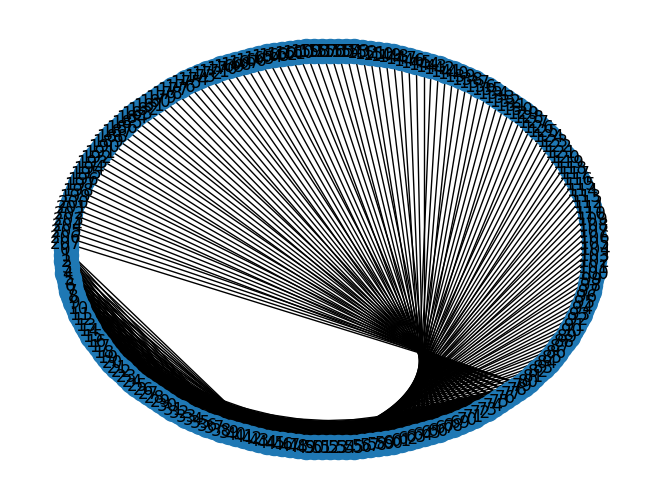

In [94]:
# G2, servers2 = create_fat_tree_v2(ports_per_switch=2)
# G2, servers2 = create_fat_tree_v2(ports_per_switch=4)
# G2, servers2 = create_fat_tree_v2(ports_per_switch=6)
G2, servers2 = create_fat_tree_v2(ports_per_switch=8)
print(servers2)
# print(nx.shortest_path_length(G2, source=20, target=35))
pos = nx.shell_layout(G2)
nx.draw(G2, pos, with_labels=True)
plt.show()

switches 96 servers 128
range(96, 224)


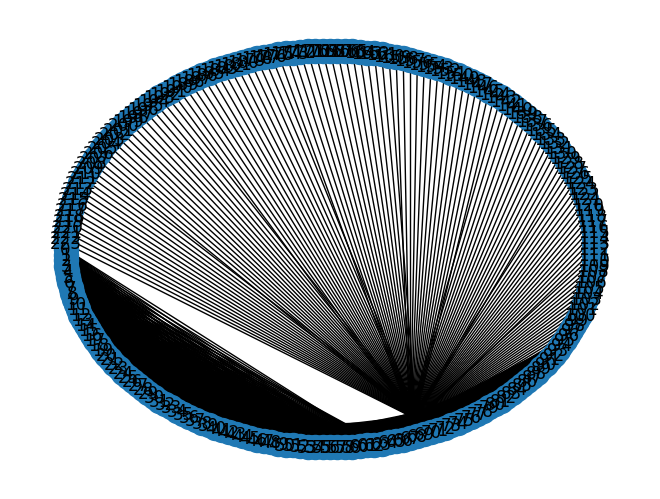

In [95]:
# G2, servers2 = create_fattree(ports_per_switch=2)
# G2, servers2 = create_fattree(ports_per_switch=4)
# G2, servers2 = create_fattree(ports_per_switch=6)
G2, servers2 = create_fattree(ports_per_switch=8)
print(servers2)
# print(nx.shortest_path_length(G2, source=20, target=35))
pos = nx.shell_layout(G2)
nx.draw(G2, pos, with_labels=True)
plt.show()

In [93]:
for i, j in G2.edges:
    print(i, j)

0 4
0 6
0 8
0 10
1 4
1 6
1 8
1 10
2 5
2 7
2 9
2 11
3 5
3 7
3 9
3 11
4 12
4 13
5 12
5 13
6 14
6 15
7 14
7 15
8 16
8 17
9 16
9 17
10 18
10 19
11 18
11 19
12 20
12 21
13 22
13 23
14 24
14 25
15 26
15 27
16 28
16 29
17 30
17 31
18 32
18 33
19 34
19 35


In [18]:
calculate_weighted_path_length(G2, servers2, edge_weight=None)

Uniform traffic 4.771653543307087
Random traffic 4.77791741657073
Gaussian traffic 4.78145997639393
Zipf traffic 4.781531321480646


In [19]:
def core_weight(source, target, edge_attr):
    if source in core_switches or target in core_switches:
        return int(np.sqrt(2*core_switches)) + 1
    else:
        return 1

In [20]:
for k in [4, 6, 8]:
    G2, servers2 = create_fattree(ports_per_switch=k)
    core_switches = k ** 2 // 2
    calculate_weighted_path_length(G2, servers2, edge_weight=core_switches)
    print("\n")


switches 24 servers 16
Uniform traffic 4.666666666666666
Random traffic 4.68768566025229
Gaussian traffic 4.626920610119526
Zipf traffic 4.626146010186757


switches 54 servers 54
Uniform traffic 4.716981132075474
Random traffic 4.712110274355451
Gaussian traffic 4.722204989680837
Zipf traffic 4.727477447107068


switches 96 servers 128
Uniform traffic 4.771653543307087
Random traffic 4.76530502338661
Gaussian traffic 4.772608437983536
Zipf traffic 4.7985483736345955




In [21]:
for (num_switches, k) in [(24, 4), (54, 6), (96, 8)]:
    G, servers = create_jellyfish(num_switches=num_switches, other_switches_per_switch=k//2, servers_per_switch=k//2)
    calculate_weighted_path_length(G, servers, edge_weight=None)
    calculate_weighted_path_length(G, servers, edge_weight=switch_weight)
    print("\n")

NetworkXNoPath: No path between 37 and 46.

In [22]:
# more switch-switch connections
for (num_switches, k) in [(24, 4), (54, 6), (96, 8)]:
    G, servers = create_jellyfish(num_switches=num_switches, other_switches_per_switch=k-k//3, servers_per_switch=k//3)
    calculate_weighted_path_length(G, servers, edge_weight=None)
    calculate_weighted_path_length(G, servers, edge_weight=switch_weight)
    print("\n")

Uniform traffic 4.945652173913043
Random traffic 4.915156061260447
Gaussian traffic 5.014958882001746
Zipf traffic 4.924064040794136
Uniform traffic 12.187331070173908
Random traffic 12.435146110994955
Gaussian traffic 12.615451060551646
Zipf traffic 12.271956454737966


Uniform traffic 4.917272412599515
Random traffic 4.918963461565058
Gaussian traffic 4.89881405070952
Zipf traffic 4.934934259441504
Uniform traffic 47.40131746885981
Random traffic 47.387008184646035
Gaussian traffic 47.74314336441752
Zipf traffic 47.03683937848784


Uniform traffic 4.693499127399651
Random traffic 4.687651361759873
Gaussian traffic 4.687257125410324
Zipf traffic 4.702006941354026
Uniform traffic 76.52221980871204
Random traffic 76.76305301826581
Gaussian traffic 76.50309586673346
Zipf traffic 77.32005577855567




In [23]:
# match number of servers
for (num_servers, k) in [(16, 4), (54, 6), (128, 8)]:
    num_switches = num_servers // (k // 3)
    G, servers = create_jellyfish(num_switches=num_switches, other_switches_per_switch=k-k//3, servers_per_switch=k//3)
    calculate_weighted_path_length(G, servers, edge_weight=None)
    calculate_weighted_path_length(G, servers, edge_weight=switch_weight)
    print("\n")

Uniform traffic 4.541666666666667
Random traffic 4.608276808412733
Gaussian traffic 4.477560251933572
Zipf traffic 4.637351443123938
Uniform traffic 7.860117052666666
Random traffic 8.071454933673726
Gaussian traffic 7.871526114005348
Zipf traffic 7.707289819001695


Uniform traffic 4.373165618448638
Random traffic 4.374426652403985
Gaussian traffic 4.406459317853219
Zipf traffic 4.342207889735092
Uniform traffic 20.466709722415096
Random traffic 20.36840110128648
Gaussian traffic 20.53539646584855
Zipf traffic 20.829232626186112


Uniform traffic 4.4547244094488185
Random traffic 4.460644589968176
Gaussian traffic 4.464891996950026
Zipf traffic 4.4391119310979565
Uniform traffic 47.27729008705512
Random traffic 47.2859830062599
Gaussian traffic 47.402594472057196
Zipf traffic 47.524212799346245




# Multicommodity Flow

## Jellyfish
Variables: 1 for each server, 1 for each switch

Model edges -> each have 1 var per commodity

Assume each switch connects to $r$ switches and $k - r$ servers.

If $n$ switches and $m = n(k - r)$ servers (have $m^2 flows$),

edges: $nr / 2 + n(k - r)$

complexity:

$m^2 \cdot E = m^2 (nr / 2 + n(k - r))$ variables

$m^2 \cdot V + E = m^2(n + n(k - r)) + nr / 2 + n (k - r)$ constraints

each var >= 0

In [10]:
import gurobipy as gp
from gurobipy import GRB

In [11]:
def create_gurobi_LP_basic(num_switches, other_switches_per_switch, servers_per_switch, genfn, *args, **kwargs):
    n = num_switches
    r = other_switches_per_switch
    k = servers_per_switch + r
    tot_server = n * (k - r)

    G, serverlist = create_jellyfish(num_switches, other_switches_per_switch, servers_per_switch)
    serverlist = list(serverlist)
    # print(len(serverlist), tot_server)


    server_dist = genfn(n=tot_server, **kwargs)
#     print(server_dist)

    grf = generate_traffic_matrix(server_dist, server_dist) # gives the commodities
#     print(grf)
    n_vars = n * r // 2 + tot_server
    vars = []
    n_vertex = len(G)

    for i in serverlist:
        for j in serverlist:
            if (i == j): continue
            var_name = f'var_{i},{j}_'
            for x,y in G.edges:
                vars.append(var_name+f'{x},{y}')
                vars.append(var_name+f'{y},{x}')
    
    m = gp.Model("mcf")

    edgelist = list(G.edges)
    for i in range(len(G.edges)):
        edgelist.append((edgelist[i][1], edgelist[i][0]))
    edgelist.sort()
    # print(edgelist)
#     flowvars = m.continuous_var_dict(filter(lambda p: p[0] != p[1], ((i, j, x, y) for i in serverlist for j in serverlist for x, y in edgelist)),
#                                      lb=0,
#                                      name="flow_edge")
    var_keys = list(filter(lambda p: p[0] != p[1], ((i, j, x, y) for i in serverlist for j in serverlist for x, y in edgelist)))
    flow = m.addVars(var_keys, name="flow_edge")
#     print(flow)
    
    for i in serverlist:
        for j in serverlist:
            if (i == j): continue
            m.addConstrs(
                (flow.sum(i,j,v,'*') - flow.sum(i,j,'*',v) == (grf[i-n][j-n] if v == i else -grf[i-n][j-n] if v == j else 0) for v in G.nodes), f"cons_{i}_{j}")
#             for v in G.nodes:
#                 m.add_constraint(m.eq_constraint(m.sum(flowvars[i,j,v,x] for _,x in filter(lambda p: p[0] == v, edgelist)),
#                                                  m.sum(flowvars[i,j,x,v] for x,_ in filter(lambda p: p[1] == v, edgelist)) +
#                                                  (grf[i-n][j-n] if v == i else -grf[i-n][j-n] if v == j else 0)),
#                                  ctname=f"cons_{i}_{j}_v{v}")
    # print(len(flowvars), tot_server)
    z = m.addVar(name="z")
#     z = m.continuous_var(name="z", lb=0)
    for i in serverlist:
        for j in serverlist:
            if (i == j): continue
            for x, y in edgelist:
                m.addConstr(flow[(i, j, x, y)] <= z)
#     m.minimize(z)
    m.setObjective(z, GRB.MINIMIZE)
#     m.print_information()
    return m, grf, server_dist, G, serverlist

In [55]:
fmodel, grf, server_dist, _, _= create_gurobi_LP(24,3,1, generate_unif)

In [56]:
np.max(grf)

0.0018115942028985505

In [57]:
fmodel.optimize()

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[rosetta2])

CPU model: Apple M1 Max
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 92736 rows, 66241 columns and 264960 nonzeros
Model fingerprint: 0x8872c4ca
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-03, 2e-03]
Presolve removed 40296 rows and 26496 columns
Presolve time: 0.11s
Presolved: 52440 rows, 39745 columns, 155664 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.01s

Barrier performed 0 iterations in 0.22 seconds (0.19 work units)
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Iteration    Objective       Primal Inf.    Dual Inf.      Time
    1998    1.8115942e-03   0.000000e+00   0.000000e+00      0s

Solved in 1998 iterations and 0.25 seconds (0.2

## Throughput calculation

In [12]:
def construct_tm_dist(G, serverlist, genfn, *args, **kwargs):
    tot_server = len(serverlist)
    n = len(G) - tot_server
    print(tot_server, n)
    server_dist = genfn(n=tot_server, **kwargs)
#     print(server_dist)

    grf = generate_traffic_matrix(server_dist, server_dist) # gives the traffic from one node to another
#     print(grf)
    return n, tot_server, server_dist, grf

In [13]:
def create_gurobi_LP_throughput_graph(G, serverlist, n, tot_server, server_dist, grf, *args, **kwargs):
    """
    Takes in graph G, serverlist, distribution function genfn + kwargs
    Returns model, TM, distribution
    """
#     n = num_switches
#     r = other_switches_per_switch
#     k = servers_per_switch + r
#     tot_server = n * (k - r)

#     tot_server = len(serverlist)
#     n = len(G) - tot_server
#     print(tot_server, n)
#     server_dist = genfn(n=tot_server, **kwargs)
# #     print(server_dist)

#     grf = generate_traffic_matrix(server_dist, server_dist) # gives the traffic from one node to another
# #     print(grf)

    m = gp.Model("mcf_throughput")

    edgelist = list(G.edges)
    for i in range(len(G.edges)):
        edgelist.append((edgelist[i][1], edgelist[i][0]))
    edgelist.sort()
    # print(edgelist)
#     flowvars = m.continuous_var_dict(filter(lambda p: p[0] != p[1], ((i, j, x, y) for i in serverlist for j in serverlist for x, y in edgelist)),
#                                      lb=0,
#                                      name="flow_edge")
    var_keys = list(filter(lambda p: p[0] != p[1], ((i, j, x, y) for i in serverlist for j in serverlist for x, y in edgelist)))
    flow = m.addVars(var_keys, name="flow_edge")
#     print(flow)

    tput = m.addVar(name="throughput")
    
    for i in serverlist:
        for j in serverlist:
            if (i == j): continue
            m.addConstrs(
                (flow.sum(i,j,v,'*') - flow.sum(i,j,'*',v) == tput * (grf[i-n][j-n] if v == i else -grf[i-n][j-n] if v == j else 0) for v in G.nodes), f"cons_{i}_{j}")
#             for v in G.nodes:
#                 m.add_constraint(m.eq_constraint(m.sum(flowvars[i,j,v,x] for _,x in filter(lambda p: p[0] == v, edgelist)),
#                                                  m.sum(flowvars[i,j,x,v] for x,_ in filter(lambda p: p[1] == v, edgelist)) +
#                                                  (grf[i-n][j-n] if v == i else -grf[i-n][j-n] if v == j else 0)),
#                                  ctname=f"cons_{i}_{j}_v{v}")
    # print(len(flowvars), tot_server)
    
    # Add capacity constraints for switch-switch edges
    for i in range(n):
        for j in range(n):
            if (i == j): continue
            m.addConstr(
                (flow.sum("*", "*", i, j) <= 1), name="switchcap"
            )

    m.setObjective(tput, GRB.MAXIMIZE)
    
    return m, grf, server_dist

In [112]:
G, serverlist = create_jellyfish(num_switches=16, other_switches_per_switch=3, servers_per_switch=1)
serverlist = list(serverlist)

In [113]:
n, tot_server, server_dist, grf = construct_tm_dist(G, serverlist, generate_unif)

16 16


In [114]:
tputm, mtrx, dst = create_gurobi_LP_throughput_graph(G, serverlist, n, tot_server, server_dist, grf)

In [115]:
tputm.optimize()

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[rosetta2])

CPU model: Apple M1 Max
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 7920 rows, 19201 columns and 50400 nonzeros
Model fingerprint: 0x0acd01ad
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 4272 rows and 7680 columns
Presolve time: 0.03s
Presolved: 3648 rows, 11521 columns, 33472 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.01s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 2.699e+04
 Factor NZ  : 1.143e+05 (roughly 7 MB of memory)
 Factor Ops : 4.227e+06 (less than 1 second per iteration)
 Threads    : 8

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.28000000e+01  1.

In [104]:
G2, sl2 = create_fat_tree_v2(4)
sl2 = list(sl2)
n2, tot_server2, server_dist2, grf2 = construct_tm_dist(G2, sl2, generate_unif)

Tot switch: 20 Tot server: 16
16 20


In [105]:
tputm_ft, _, _ = create_gurobi_LP_throughput_graph(G2, sl2, n2, tot_server2, server_dist2, grf2)

In [106]:
tputm_ft.optimize()

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[rosetta2])

CPU model: Apple M1 Max
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 9020 rows, 23041 columns and 61920 nonzeros
Model fingerprint: 0xeaf98434
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 4412 rows and 7712 columns
Presolve time: 0.02s
Presolved: 4608 rows, 15329 columns, 44544 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 1.424e+04
 Factor NZ  : 5.524e+04 (roughly 3 MB of memory)
 Factor Ops : 2.538e+06 (less than 1 second per iteration)
 Threads    : 8

Barrier performed 0 iterations in 0.06 seconds (0.06 work units)
Barrier solve interrupted - model solved by another algorithm


Solved with dual simpl

In [118]:
tputm.printStats()


Statistics for modelmcf_throughput:
  Linear constraint matrix    : 7920 Constrs, 19201 Vars, 50400 NZs
  Matrix coefficient range    : [ 0.00416667, 1 ]
  Objective coefficient range : [ 1, 1 ]
  Variable bound range        : [ 0, 0 ]
  RHS coefficient range       : [ 1, 1 ]


In [119]:
G, serverlist = create_jellyfish(num_switches=80, other_switches_per_switch=3, servers_per_switch=2)
serverlist = list(serverlist)
n, tot_server, server_dist, grf = construct_tm_dist(G, serverlist, generate_unif)
tputm, mtrx, dst = create_gurobi_LP_throughput_graph(G, serverlist, n, tot_server, server_dist, grf)
tputm.optimize()

160 80
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[rosetta2])

CPU model: Apple M1 Max
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 6111920 rows, 14246401 columns and 34649280 nonzeros
Model fingerprint: 0x9378782a
Coefficient statistics:
  Matrix range     [4e-05, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 6080 rows and 0 columns (presolve time = 5s) ...
Presolve removed 56960 rows and 4121280 columns (presolve time = 10s) ...
Presolve removed 56960 rows and 4121280 columns (presolve time = 15s) ...
Presolve removed 4076480 rows and 4121280 columns (presolve time = 20s) ...
Presolve removed 4076480 rows and 8140800 columns (presolve time = 25s) ...
Presolve removed 4076480 rows and 8140800 columns
Presolve time: 25.64s
Presolved: 2035440 rows, 6105601 columns, 18367360 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, an

 1186404    1.8832382e+35   3.247299e+36   1.883238e+05    573s
 1187536    1.8227110e+35   3.260315e+36   1.822711e+05    575s
 1194902    1.8115589e+35   3.383877e+36   1.811559e+05    593s
 1201166    1.5474409e+35   2.868185e+36   1.547441e+05    633s
 1206178    1.5207640e+35   2.815779e+36   1.520764e+05    659s
 1212231    1.4957172e+35   2.643069e+36   1.495717e+05    684s
 1218252    1.4675423e+35   2.633823e+36   1.467543e+05    702s
 1221580    1.4425484e+35   2.609155e+36   1.442549e+05    705s
 1225180    1.4274089e+35   2.458109e+36   1.427409e+05    743s
 1232014    1.4164751e+35   2.348057e+36   1.416475e+05    761s
 1238250    1.4025676e+35   2.445348e+36   1.402568e+05    765s
 1243922    1.3866196e+35   2.124328e+36   1.386620e+05    780s
 1250379    1.3773470e+35   2.039460e+36   1.377347e+05    807s
 1255511    1.3603743e+35   2.187349e+36   1.360375e+05    835s
 1256833    1.3378035e+35   2.042944e+36   1.337804e+05    857s
 1258599    1.3144756e+35   3.544594e+36

In [123]:
# G, serverlist = create_jellyfish(num_switches=80, other_switches_per_switch=3, servers_per_switch=2)
# serverlist = list(serverlist)
n2, tot_server2, server_dist2, grf2 = construct_tm_dist(G, serverlist, generate_random)
tputm2, _, _ = create_gurobi_LP_throughput_graph(G, serverlist, n2, tot_server2, server_dist2, grf2)
print('Model created')
tputm2.optimize()

160 80
Model created
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[rosetta2])

CPU model: Apple M1 Max
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 6111920 rows, 14246401 columns and 34649280 nonzeros
Model fingerprint: 0x16021ca1
Coefficient statistics:
  Matrix range     [2e-08, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 6080 rows and 0 columns (presolve time = 6s) ...
Presolve removed 15680 rows and 4080000 columns (presolve time = 11s) ...
Presolve removed 56960 rows and 4121280 columns (presolve time = 16s) ...
Presolve removed 56960 rows and 4121280 columns (presolve time = 20s) ...
Presolve removed 4076480 rows and 8140800 columns (presolve time = 27s) ...
Presolve removed 4076480 rows and 8140800 columns
Presolve time: 27.14s
Presolved: 2035440 rows, 6105601 columns, 18367360 nonzeros

Concurrent LP optimizer: primal simplex, dual

In [124]:
n3, tot_server3, server_dist3, grf3 = construct_tm_dist(G, serverlist, generate_zipf)
tputm3, _, _ = create_gurobi_LP_throughput_graph(G, serverlist, n3, tot_server3, server_dist3, grf3)
print('Model created')
tputm3.optimize()

160 80
Model created
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[rosetta2])

CPU model: Apple M1 Max
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 6111920 rows, 14246401 columns and 34649280 nonzeros
Model fingerprint: 0xa91a27a0
Coefficient statistics:
  Matrix range     [1e-06, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 6080 rows and 0 columns (presolve time = 5s) ...
Presolve removed 56960 rows and 4121280 columns (presolve time = 10s) ...
Presolve removed 56960 rows and 4121280 columns (presolve time = 17s) ...
Presolve removed 4076480 rows and 8140800 columns (presolve time = 21s) ...
Presolve removed 4076480 rows and 8140800 columns
Presolve time: 24.24s
Presolved: 2035440 rows, 6105601 columns, 18367360 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...


Interrupt request rece

In [125]:
n3, tot_server3, server_dist3, grf3 = construct_tm_dist(G, serverlist, generate_gaussian)
tputm3, _, _ = create_gurobi_LP_throughput_graph(G, serverlist, n3, tot_server3, server_dist3, grf3)
print('Model created')
tputm3.optimize()

160 80
Model created
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[rosetta2])

CPU model: Apple M1 Max
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 6111920 rows, 14246401 columns and 34649280 nonzeros
Model fingerprint: 0x11a7e751
Coefficient statistics:
  Matrix range     [7e-09, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 6080 rows and 0 columns (presolve time = 6s) ...
Presolve removed 15680 rows and 4080000 columns (presolve time = 11s) ...
Presolve removed 56960 rows and 4121280 columns (presolve time = 17s) ...
Presolve removed 56960 rows and 4121280 columns (presolve time = 21s) ...
Presolve removed 4076480 rows and 8140800 columns (presolve time = 25s) ...
Presolve removed 4076480 rows and 8140800 columns
Presolve time: 29.05s
Presolved: 2035440 rows, 6105601 columns, 18367360 nonzeros

Concurrent LP optimizer: primal simplex, dual

In [126]:
print('test')

test


In [127]:
n5, tot_server5, server_dist5, grf5 = construct_tm_dist(G, serverlist, generate_zipf)
tputm5, _, _ = create_gurobi_LP_throughput_graph(G, serverlist, n5, tot_server5, server_dist5, grf5)
print('Model created')
tputm5.optimize()

160 80
Model created
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[rosetta2])

CPU model: Apple M1 Max
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 6111920 rows, 14246401 columns and 34649280 nonzeros
Model fingerprint: 0xa91a27a0
Coefficient statistics:
  Matrix range     [1e-06, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 6080 rows and 0 columns (presolve time = 5s) ...
Presolve removed 55680 rows and 4120000 columns (presolve time = 10s) ...
Presolve removed 56960 rows and 4121280 columns (presolve time = 16s) ...
Presolve removed 56960 rows and 4121280 columns (presolve time = 20s) ...
Presolve removed 4076480 rows and 8140800 columns (presolve time = 25s) ...
Presolve removed 4076480 rows and 8140800 columns
Presolve time: 29.08s
Presolved: 2035440 rows, 6105601 columns, 18367360 nonzeros

Concurrent LP optimizer: primal simplex, dual

In [14]:
print("test")

test


In [59]:

import random

In [64]:
def create_gurobi_LP_throughput_randpermmtrx(G, serverlist, *args, **kwargs):
    """
    Takes in graph G, serverlist, distribution function genfn + kwargs
    Returns model, TM, distribution
    """
#     n = num_switches
#     r = other_switches_per_switch
#     k = servers_per_switch + r
#     tot_server = n * (k - r)

#     tot_server = len(serverlist)
#     n = len(G) - tot_server
#     print(tot_server, n)
#     server_dist = genfn(n=tot_server, **kwargs)
# #     print(server_dist)

#     grf = generate_traffic_matrix(server_dist, server_dist) # gives the traffic from one node to another
# #     print(grf)

    tot_server = len(serverlist)
    n = len(G) - tot_server
    print(tot_server, n)
    server_dist = serverlist[::]
    random.shuffle(server_dist)
    
    output_rates = np.ones(tot_server)
    output_rates /= np.linalg.norm(output_rates)

    m = gp.Model("mcf_throughput")

    edgelist = list(G.edges)
    for i in range(len(G.edges)):
        edgelist.append((edgelist[i][1], edgelist[i][0]))
    edgelist.sort()
    # print(edgelist)
#     flowvars = m.continuous_var_dict(filter(lambda p: p[0] != p[1], ((i, j, x, y) for i in serverlist for j in serverlist for x, y in edgelist)),
#                                      lb=0,
#                                      name="flow_edge")
    var_keys = list(filter(lambda p: p[0] != p[1], ((i, j, x, y) for i in serverlist for j in serverlist for x, y in edgelist)))
    flow = m.addVars(var_keys, name="flow_edge")
#     print(flow)

    tput = m.addVar(name="throughput")
    
    for idx, i in enumerate(server_dist):
        m.addConstrs(
            (flow.sum(server_dist[idx-1],i,v,'*') - flow.sum(server_dist[idx-1],i,'*',v) == tput * (output_rates[0] if v == server_dist[idx - 1] else -output_rates[0] if v == i else 0) for v in G.nodes),
            f"cons_{server_dist[idx-1]}_{i}"
        )
    
    # Add capacity constraints for switch-switch edges
    for i in range(n):
        for j in range(n):
            if (i == j): continue
            m.addConstr(
                (flow.sum("*", "*", i, j) <= 1), name="switchcap"
            )

    m.setObjective(tput, GRB.MAXIMIZE)
    
    return m, grf, server_dist

In [128]:
G, serverlist = create_jellyfish(num_switches=24, other_switches_per_switch=5, servers_per_switch=2)
serverlist = list(serverlist)

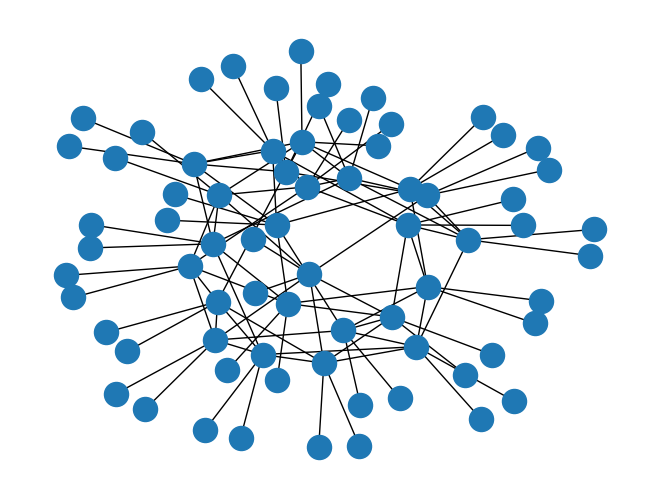

In [129]:
nx.draw(G)
plt.show()

In [130]:
n, tot_server, server_dist, grf = construct_tm_dist(G, serverlist, generate_unif)
tputm, mtrx, dst = create_gurobi_LP_throughput_graph(G, serverlist, n, tot_server, server_dist, grf)
print('Model created')
tputm.optimize()

48 24
Model created
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[rosetta2])

CPU model: Apple M1 Max
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 162984 rows, 487297 columns and 1249824 nonzeros
Model fingerprint: 0x0934abb5
Coefficient statistics:
  Matrix range     [4e-04, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 108768 rows and 216576 columns
Presolve time: 0.44s
Presolved: 54216 rows, 270721 columns, 816096 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.01s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 6.805e+05
 Factor NZ  : 7.224e+06 (roughly 200 MB of memory)
 Factor Ops : 9.660e+08 (less than 1 second per iteration)
 Threads    : 8

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl 

In [131]:
n2, tot_server2, server_dist2, grf2 = construct_tm_dist(G, serverlist, generate_random)
tputm2, _, _ = create_gurobi_LP_throughput_graph(G, serverlist, n2, tot_server2, server_dist2, grf2)
print('Model created')
tputm2.optimize()

48 24
Model created
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[rosetta2])

CPU model: Apple M1 Max
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 162984 rows, 487297 columns and 1249824 nonzeros
Model fingerprint: 0xfa4b5434
Coefficient statistics:
  Matrix range     [4e-07, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 108768 rows and 216576 columns
Presolve time: 0.45s
Presolved: 54216 rows, 270721 columns, 816096 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.01s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 6.805e+05
 Factor NZ  : 7.224e+06 (roughly 200 MB of memory)
 Factor Ops : 9.660e+08 (less than 1 second per iteration)
 Threads    : 8

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl 

In [132]:
n3, tot_server3, server_dist3, grf3 = construct_tm_dist(G, serverlist, generate_gaussian)
tputm3, _, _ = create_gurobi_LP_throughput_graph(G, serverlist, n3, tot_server3, server_dist3, grf3)
print('Model created')
tputm3.optimize()

48 24
Model created
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[rosetta2])

CPU model: Apple M1 Max
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 162984 rows, 487297 columns and 1249824 nonzeros
Model fingerprint: 0x5dd51342
Coefficient statistics:
  Matrix range     [8e-08, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 108768 rows and 216576 columns
Presolve time: 0.48s
Presolved: 54216 rows, 270721 columns, 816096 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...


Interrupt request received
Ordering time: 0.01s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 6.805e+05
 Factor NZ  : 7.224e+06 (roughly 200 MB of memory)
 Factor Ops : 9.660e+08 (less than 1 second per iteration)
 Threads    : 8

                  Objective                Residual
Iter       Primal          Dual      

In [133]:
n4, tot_server4, server_dist4, grf4 = construct_tm_dist(G, serverlist, generate_zipf)
tputm4, _, _ = create_gurobi_LP_throughput_graph(G, serverlist, n4, tot_server4, server_dist4, grf4)
print('Model created')
tputm4.optimize()

48 24
Model created
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[rosetta2])

CPU model: Apple M1 Max
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 162984 rows, 487297 columns and 1249824 nonzeros
Model fingerprint: 0xa5feb89c
Coefficient statistics:
  Matrix range     [2e-05, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 108768 rows and 216576 columns
Presolve time: 0.47s
Presolved: 54216 rows, 270721 columns, 816096 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...


Interrupt request received
Ordering time: 0.01s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 6.805e+05
 Factor NZ  : 7.224e+06 (roughly 200 MB of memory)
 Factor Ops : 9.660e+08 (less than 1 second per iteration)
 Threads    : 8

                  Objective                Residual
Iter       Primal          Dual      

In [134]:
tputm5, _, _ = create_gurobi_LP_throughput_randpermmtrx(G, serverlist)
print("Model created")
tputm5.optimize()

48 24
Model created
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[rosetta2])

CPU model: Apple M1 Max
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 4008 rows, 487297 columns and 291552 nonzeros
Model fingerprint: 0xa6487384
Coefficient statistics:
  Matrix range     [1e-01, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 2736 rows and 481536 columns
Presolve time: 0.07s
Presolved: 1272 rows, 5761 columns, 17374 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...


Interrupt request received
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.876e+04
 Factor NZ  : 9.991e+04 (roughly 4 MB of memory)
 Factor Ops : 1.104e+07 (less than 1 second per iteration)
 Threads    : 8

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl